# DEPENDENCIES

In [ ]:
!pip install torch torchvision transformers datasets matplotlib pandas scikit-learn wordcloud
!pip install --upgrade --force-reinstall fsspec datasets

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.33.2-py3-none-any.whl.metadata (14 kB)
  Using cached packaging-25.0-py

# Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import numpy as np

# Graph Styles

In [ ]:
plt.style.use('fivethirtyeight')

# Visulization

In [ ]:
class NewsVisualizer:
    @staticmethod
    def plot_category_distribution(df, title, colors):
        fig, ax = plt.subplots(figsize=(5,3))
        vals = df['label'].value_counts().sort_index()
        vals.plot(kind='bar', color=colors, edgecolor='#161925', ax=ax)
        ax.set_xticks(range(4))
        ax.set_xticklabels(['World', 'Sports', 'Business', 'Tech'], fontsize=12, rotation=10)
        ax.set_title(title, fontsize=13, fontweight='bold', color='#ce4257')
        ax.set_ylabel('Number of Articles')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_text_length(df, color):
        df['len_words'] = df['text'].apply(lambda t: len(t.split()))
        plt.figure(figsize=(6,2.6))
        plt.hist(df['len_words'], bins=30, color=color, edgecolor='#e0fbfc', alpha=0.85)
        plt.title('Distribution of Word Counts', fontsize=12, color='#1b263b')
        plt.xlabel('Words in Article')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='-.', alpha=0.35)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_wordclouds(df, cmaps):
        for idx, label, cmap in zip(range(4), ['World', 'Sports', 'Business', 'Tech'], cmaps):
            wc_text = " ".join(df[df['label'] == idx]['text'])
            wc = WordCloud(width=720, height=230, background_color='white', colormap=cmap).generate(wc_text)
            plt.figure(figsize=(7.3,2.3))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f"{label} Word Cloud", fontsize=12, color='#2b2d42')
            plt.tight_layout()
            plt.show()

    @staticmethod
    def plot_training_curve(losses, color):
        plt.figure(figsize=(6,3.3))
        plt.plot(range(1, len(losses)+1), losses, marker='h', color=color, linewidth=2)
        plt.title('Model Training Loss', fontsize=13, color='#4361ee')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_confusion(y_true, y_pred, class_labels, cm_color):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
        fig, ax = plt.subplots(figsize=(6,5))
        disp.plot(cmap=cm_color, ax=ax, colorbar=False)
        plt.title('Validation Confusion Matrix', fontsize=13, color='#ef476f')
        plt.show()


# Loading the Dataset

In [ ]:
class ArticleBertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, i):
        enc = self.tokenizer(self.texts[i], truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        batch = {k: v.squeeze(0) for k, v in enc.items()}
        batch['labels'] = torch.tensor(self.labels[i], dtype=torch.long)
        return batch

# Model Development and Training

In [ ]:
class NewsClassifier:
    def __init__(self, n_classes=4, max_len=50, batch_size=16, epochs=10, seed=8):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.class_names = ['World', 'Sports', 'Business', 'Tech']
        self.n_classes = n_classes
        self.max_len = max_len
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.model = None
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        print(f"Device: {self.device}")

    def load_data(self):
        ds = load_dataset("ag_news")
        df_all = pd.concat([pd.DataFrame(ds['train']), pd.DataFrame(ds['test'])], ignore_index=True)
        df_all = df_all.sample(frac=1, random_state=self.seed).reset_index(drop=True)
        df_tr, df_val = train_test_split(
            df_all, train_size=4500, test_size=700,
            stratify=df_all['label'], random_state=self.seed)
        return df_tr, df_val

    def get_dataloaders(self, train_df, val_df):
        train_set = ArticleBertDataset(train_df['text'].tolist(), train_df['label'].tolist(),
                                       self.tokenizer, self.max_len)
        val_set = ArticleBertDataset(val_df['text'].tolist(), val_df['label'].tolist(),
                                     self.tokenizer, self.max_len)
        train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=self.batch_size)
        return train_loader, val_loader

    def setup_model(self):
        self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=self.n_classes)
        self.model = self.model.to(self.device)
        return self.model

    def train(self, loader):
        optimizer = AdamW(self.model.parameters(), lr=2e-5)
        criterion = nn.CrossEntropyLoss()
        loss_track = []
        self.model.train()
        for ep in range(self.epochs):
            total_loss = 0
            for batch in loader:
                ids = batch['input_ids'].to(self.device)
                mask = batch['attention_mask'].to(self.device)
                labs = batch['labels'].to(self.device)
                optimizer.zero_grad()
                output = self.model(input_ids=ids, attention_mask=mask, labels=labs)
                loss = output.loss
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg = total_loss / len(loader)
            loss_track.append(avg)
            print(f"Epoch {ep+1}/{self.epochs} | Loss: {avg:.4f}")
        return loss_track

    def predict(self, loader):
        self.model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for batch in loader:
                ids = batch['input_ids'].to(self.device)
                mask = batch['attention_mask'].to(self.device)
                labs = batch['labels'].to(self.device)
                outs = self.model(input_ids=ids, attention_mask=mask)
                p = torch.argmax(outs.logits, dim=1)
                preds.extend(p.cpu().numpy())
                trues.extend(labs.cpu().numpy())
        return np.array(preds), np.array(trues)

    def print_examples(self, x_val, y_val, y_pred, count=5):
        print("\nModel predictions on sample validation articles:\n")
        for i in range(count):
            print(f"Text: {x_val[i][:110]}...")
            print(f"True: {self.class_names[y_val[i]]} | Predicted: {self.class_names[y_pred[i]]}\n")


# Main Code

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Device: cuda


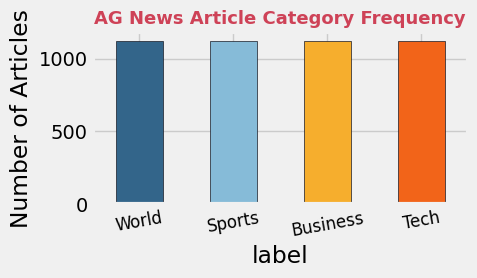

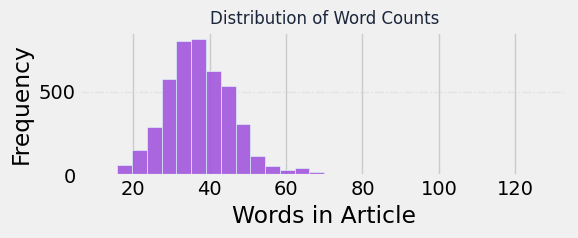

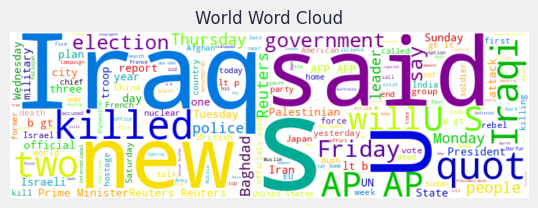

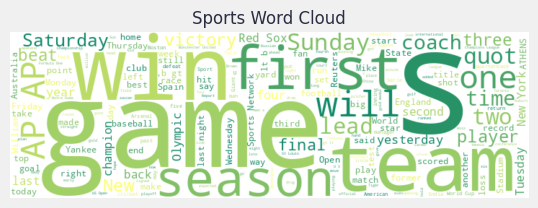

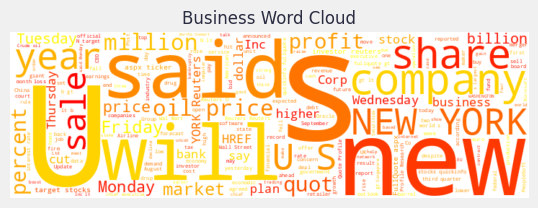

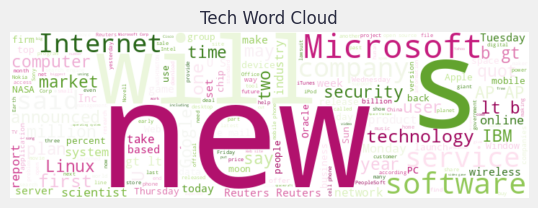

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Sample validation set articles:

Text: Strongwoman hoists 100th gold for Chinese delegation Tang Gonghong lifted a world record to claim in...
Label: Sports

Text: Tiger Woods sues yacht builder over use of his name FORT LAUDERDALE -- Tiger Woods is taking a swing...
Label: Sports

Epoch 1/10 | Loss: 0.5021
Epoch 2/10 | Loss: 0.2374
Epoch 3/10 | Loss: 0.1545
Epoch 4/10 | Loss: 0.0803
Epoch 5/10 | Loss: 0.0476
Epoch 6/10 | Loss: 0.0354
Epoch 7/10 | Loss: 0.0225
Epoch 8/10 | Loss: 0.0186
Epoch 9/10 | Loss: 0.0260
Epoch 10/10 | Loss: 0.0091


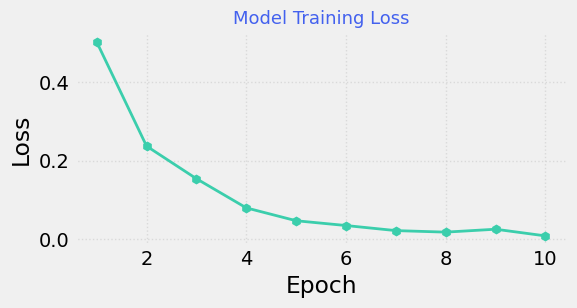


Validation Accuracy: 0.9143
Validation F1 Score: 0.9140


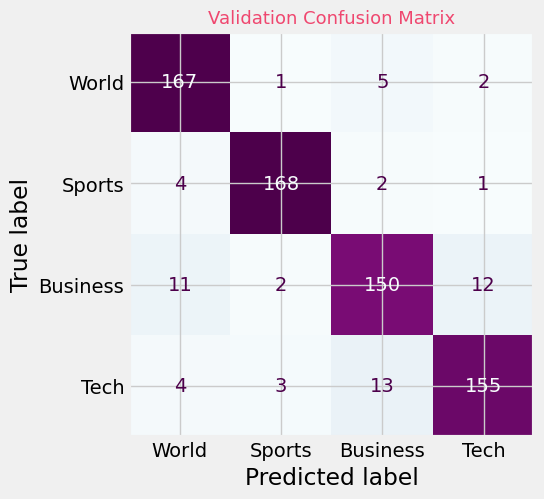


Model predictions on sample validation articles:

Text: Strongwoman hoists 100th gold for Chinese delegation Tang Gonghong lifted a world record to claim in Athens th...
True: Sports | Predicted: Sports

Text: Tiger Woods sues yacht builder over use of his name FORT LAUDERDALE -- Tiger Woods is taking a swing at the bu...
True: Sports | Predicted: Business

Text: A retooled Draper now makes what it devises CAMBRIDGE -- The hunt for terror-thwarting technology has brought ...
True: Business | Predicted: Business

Text: United Airlines Sees More Job Losses (Reuters) Reuters - The head of UAL Corp.'s United\Airlines said on Thurs...
True: Business | Predicted: Business

Text: UPDATE 1-Mexico #39;s Cemex shares tumble on RMC deal Shares of Mexico #39;s Cemex slumped on Monday after the...
True: Business | Predicted: Business



In [ ]:
def main():
    vis = NewsVisualizer()
    ag_model = NewsClassifier()

    # --- Load & visualize data ---
    df_train, df_val = ag_model.load_data()
    color_bars = ['#33658a', '#86bbd8', '#f6ae2d', '#f26419']
    color_hist = '#9d4edd'
    wordcloud_colors = ['nipy_spectral', 'summer', 'autumn', 'PiYG']

    vis.plot_category_distribution(df_train, "AG News Article Category Frequency", color_bars)
    vis.plot_text_length(df_train, color_hist)
    vis.plot_wordclouds(df_train, wordcloud_colors)

    # --- BERT model and data ---
    train_loader, val_loader = ag_model.get_dataloaders(df_train, df_val)
    ag_model.setup_model()
    print("\nSample validation set articles:\n")
    for i in range(2):
        print(f"Text: {df_val['text'].tolist()[i][:100]}...\nLabel: {ag_model.class_names[df_val['label'].tolist()[i]]}\n")

    # --- Train & evaluate ---
    epoch_losses = ag_model.train(train_loader)
    vis.plot_training_curve(epoch_losses, '#3bceac')
    y_pred, y_true = ag_model.predict(val_loader)
    val_acc = accuracy_score(y_true, y_pred)
    val_f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\nValidation Accuracy: {val_acc:.4f}")
    print(f"Validation F1 Score: {val_f1:.4f}")
    vis.plot_confusion(y_true, y_pred, ag_model.class_names, cm_color='BuPu')
    ag_model.print_examples(df_val['text'].tolist(), y_true, y_pred, count=5)

main()